In [19]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]

(<Axes: >, <matplotlib.image.AxesImage at 0x1ed29ee6610>)

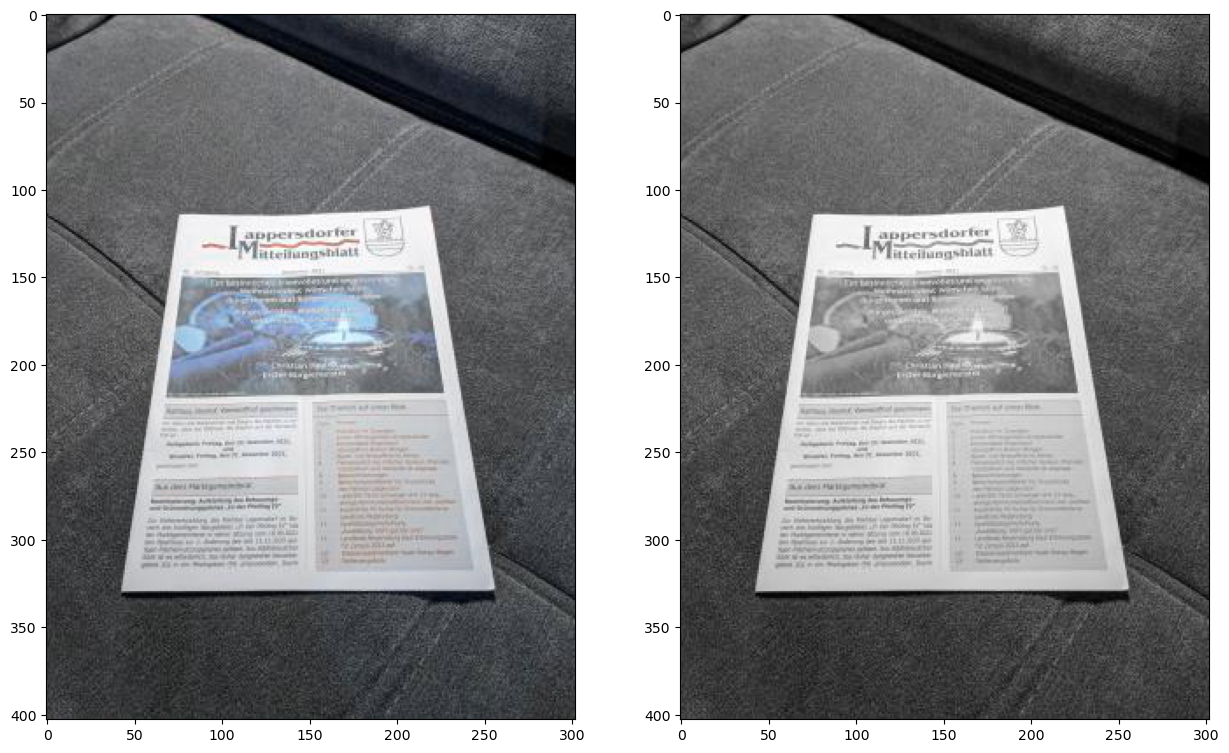

In [20]:
# Let's read the image
img = cv2.imread('document.jpg')
# Convert image to gray scale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = np.float32(gray)/255
rows, cols = gray.shape

# Let's plot the images (colour and gray scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(gray, cmap='gray')

In [21]:
# Compute Harris corners (use the available OpenCV functions)
# Suggested parameters:
#            block size of 2 pixels
#            gradient kernel size of 3 pixels
#            k parameter equal to 0.04
block_size = 2
kernel_size = 3
k_parameter = 0.04
cornerness = cv2.cornerHarris(gray, block_size, kernel_size, k_parameter)

# We are not interested in edges, so put to zero all negative cornerness values
cornerness[cornerness < 0] = 0

# Since cornerness has a huge dynamic range, let's take the logarithm for better visualization and manipulation
cornerness = np.log(cornerness + 1e-6)

(<Axes: >, <matplotlib.image.AxesImage at 0x1ed29f430d0>)

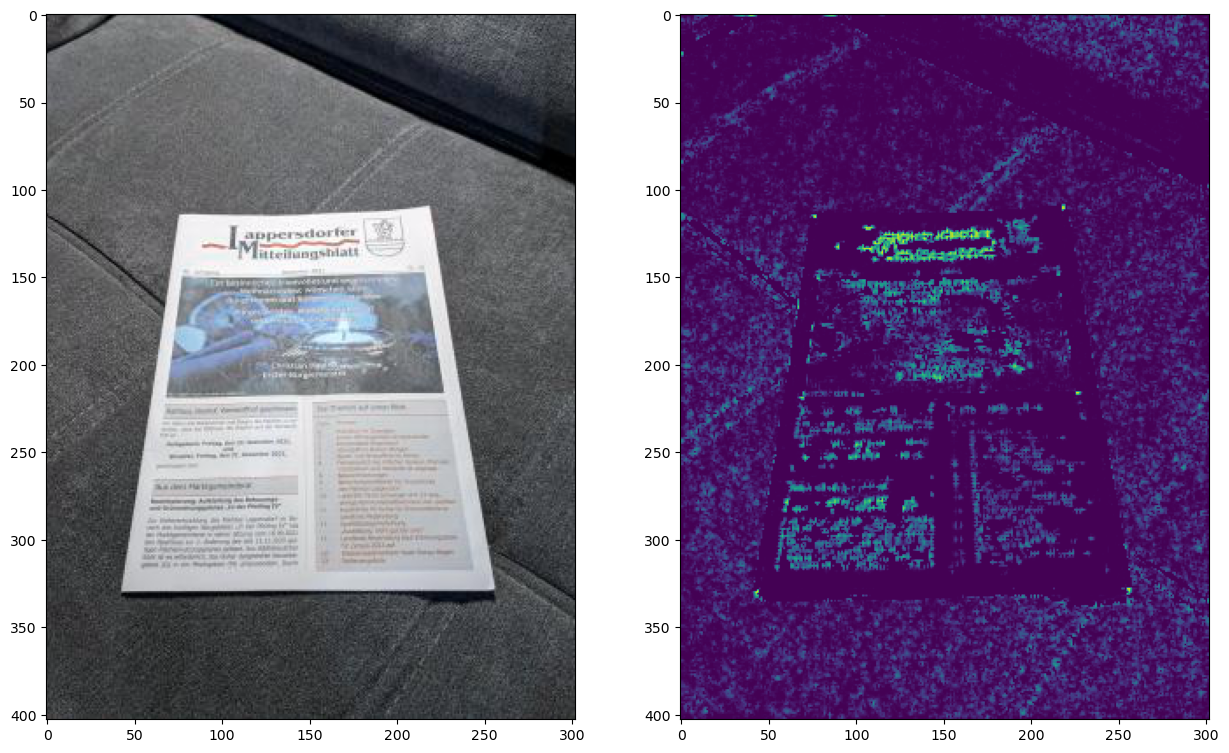

In [22]:
# Let's now plot the image and the corresponding Harris corners (in log scale)
plt.subplot(121), plt.imshow(img)
plt.subplot(122), plt.imshow(cornerness)

(<Axes: >, <matplotlib.image.AxesImage at 0x1ed2e1e30d0>)

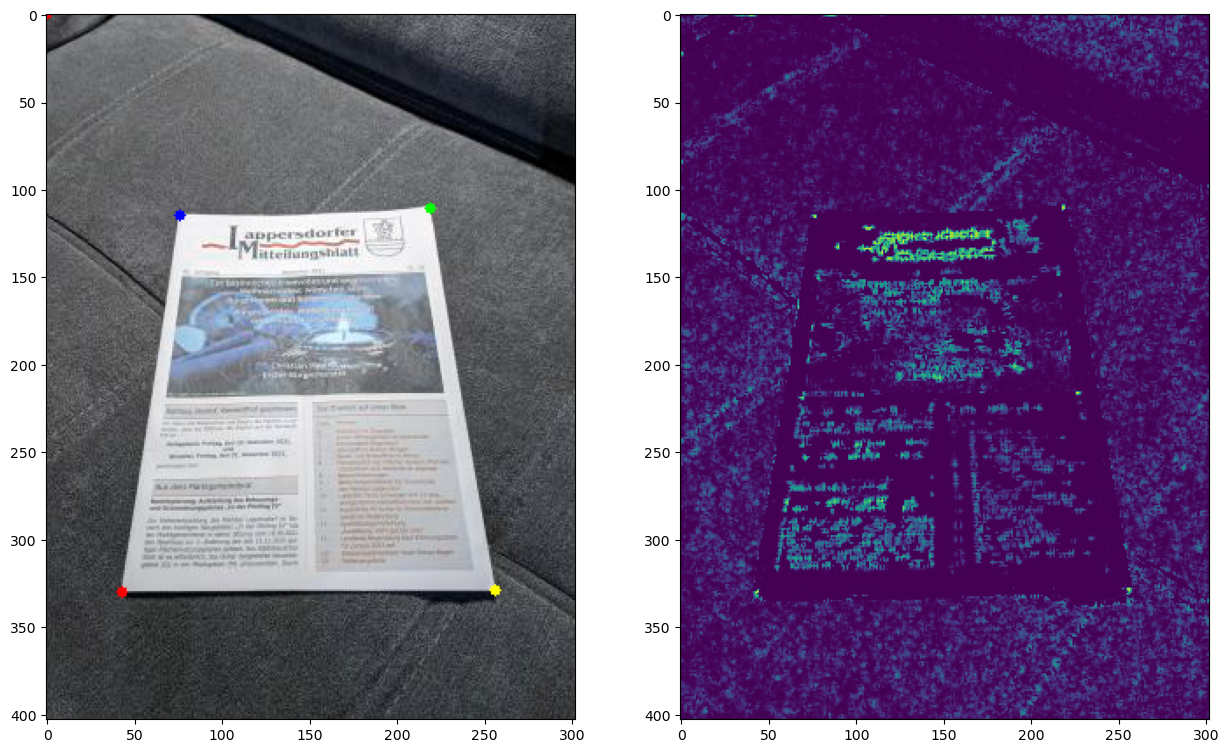

In [29]:
# Detection thresholds
th_top_left, th_top_right = -1e6, -1e6
th_bottom_left, th_bottom_right = -1e6, -1e6

# Corner coordinates
opt_top_left, opt_top_right = None, None
opt_bottom_left, opt_bottom_right = None, None

# Size of each quadrant (in pixels)
quad_size = 7

# Let's now scan the Harris detection results
for r in range(quad_size, rows-quad_size):
    for c in range(quad_size, cols-quad_size):
        # Edges with too small cornerness score are discarded, -7 seems like a good value
        if cornerness[r, c] < -7:
            continue
        
        # Extract block consisting of 4 quadrants
        block = 255*gray[r-quad_size:r+quad_size+1, c-quad_size:c+quad_size+1]
        
        # Extract the four quandrants
        quad_top_left = block[0:quad_size, 0:quad_size]
        quad_top_right = block[0:quad_size, quad_size+1:]
        quad_bottom_left = block[quad_size+1:, 0:quad_size]
        quad_bottom_right = block[quad_size+1:, quad_size+1:]

# Top-left corner
        # For the top-left document corner, the bottom-right quadrant is mostly paper and the rest is
        # darker background. Therefore, I suggest the descriptor to be the average difference between
        # the paper quandrant and the sum of the 3 remaining bakcground quandrants
        descriptor = np.mean(quad_bottom_right) - \
                     np.mean(quad_top_left) - np.mean(quad_top_right) - np.mean(quad_bottom_left)
        # Let's detect the best descriptor
        if descriptor > th_top_left:
            # We update the threshold
            th_top_left = descriptor
            # And we update the optimal location
            opt_top_left = (c, r)

# Top-right corner
        descriptor = np.mean(quad_bottom_left) - \
             np.mean(quad_top_right) - np.mean(quad_top_left) - np.mean(quad_bottom_right)
        # Let's detect the best descriptor
        if descriptor > th_top_right:
            # We update the threshold
            th_top_right = descriptor
            # And we update the optimal location
            opt_top_right = (c, r)

# Bottom-left corner
        descriptor = np.mean(quad_top_right) - \
             np.mean(quad_bottom_left) - np.mean(quad_bottom_right) - np.mean(quad_top_left)

        # Let's detect the best descriptor
        if descriptor > th_bottom_left:
            # We update the threshold
            th_bottom_left = descriptor
            # And we update the optimal location
            opt_bottom_left = (c, r)

# Bottom-right corner
        descriptor = np.mean(quad_top_left) - \
                          np.mean(quad_bottom_right) - np.mean(quad_bottom_left) - np.mean(quad_top_right)
        # Let's detect the best descriptor
        if descriptor > th_bottom_right:
            # We update the threshold
            th_bottom_right = descriptor
            # And we update the optimal location
            opt_bottom_right = (c, r)

# Let's draw circles at the detected corners
#out = cv2.circle(img, opt_top_left, 3, (255,0,0), -1)
#out = cv2.circle(img, opt_top_right, 3, (255,0,0), -1)
#out = cv2.circle(img, opt_bottom_left, 3, (255,0,0), -1)
#out = cv2.circle(img, opt_bottom_right, 3, (255,0,0), -1)

out = cv2.circle(img, opt_top_left, 3, (0, 0, 255), -1)  # blue
out = cv2.circle(img, opt_top_right, 3, (0, 255, 0), -1)  # green
out = cv2.circle(img, opt_bottom_left, 3, (255, 0, 0), -1)  # red
out = cv2.circle(img, opt_bottom_right, 3, (255, 255, 0), -1)  # yellow

# And finally we plot the images (with the detected document corners)
plt.subplot(121), plt.imshow(out)
plt.subplot(122), plt.imshow(cornerness)